# Simulación Robotic arm witch FetchPickAndPlace from Gymnasium-Robotics using Mujoco y stable baselines3

En este notebook vamos a simular y entrenar un agente(brazo robotico) en el entorno `FetchPickAndPlace-v4` utilizando `gymnasium`, `mujoco` y `stable-baselines3`.

In [ ]:
!pip install tensorboard

## Pruebas


In [ ]:
# Prueba de archivo xml para encontrar el archivo pick_and_place.xml
import os

# Ruta base a site-packages dentro de tu entorno virtual
base_dir = "./Ve_ArmSimulation2/Lib/site-packages"  # Ajusta si tu ruta es diferente

for root, dirs, files in os.walk(base_dir):
    if "pick_and_place.xml" in files:
        print(os.path.join(root, "pick_and_place.xml"))
        break


In [ ]:
# ✅ Instalar dependencias necesarias (si no están instaladas)
!pip install gymnasium[robotics] mujoco matplotlib stable-baselines3 --quiet

In [ ]:
import gymnasium_robotics
import importlib.metadata
print(importlib.metadata.version("gymnasium-robotics"))
print(gymnasium_robotics.__file__)

## 1. Simulación básica del entorno FetchPickAndPlace

In [ ]:
import os
os.environ["MUJOCO_GL"] = "glfw"

import gymnasium as gym
import gymnasium_robotics  # Importar el paquete de robótica
import numpy as np

# Crear entorno con renderizado
env = gym.make("FetchPickAndPlace-v4", render_mode="human")
obs, info = env.reset()

# Simular acciones aleatorias
for _ in range(50):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        obs, info = env.reset()

env.close()

## 2. Entrenamiento con PPO (Stable-Baselines3)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Crear entorno vectorizado
vec_env = make_vec_env("FetchPickAndPlace-v4", n_envs=1)

# Crear modelo PPO con MultiInputPolicy
model = PPO("MultiInputPolicy", vec_env, verbose=1)

# Entrenar el modelo
model.learn(total_timesteps=50_000)

# Guardar modelo
model.save("fetch_pick_and_place_ppo")
env.close()

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.8    |
|    success_rate    | 0.025    |
| time/              |          |
|    fps             | 231      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -48.8       |
|    success_rate         | 0.0247      |
| time/                   |             |
|    fps                  | 215         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004900503 |
|    clip_fraction        | 0.0265      |
|    clip_range           | 0.2         |
|    entropy_loss    

### 3. Evaluación del agente entrenado

In [ ]:
# Cargar entorno y modelo entrenado
env = gym.make("FetchPickAndPlace-v4", render_mode="human")
model = PPO.load("fetch_pick_and_place_ppo")

obs, info = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs, info = env.reset()

env.close()

# 2 Entrenamiento con SAC (Stable-Baselines3)

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import CheckpointCallback

# Crear entorno
env = gym.make("FetchPickAndPlace-v4")

# Crear directorio para guardar modelos
save_dir = "./sac_models/"
os.makedirs(save_dir, exist_ok=True)

# Callback para guardar cada 15k steps
checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_models", # Carpeta donde se guardan
    name_prefix="sac_model"        # Prefijo del archivo
)

# Crear modelo SAC
model = SAC("MultiInputPolicy", env, verbose=1, tensorboard_log="./sac_logs/")

# Entrenar con checkpoints
model.learn(total_timesteps=160_000, callback=checkpoint_callback)

# Guardar modelo final
model.save(os.path.join(save_dir, "sac_final"))

env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_logs/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 44       |
|    time_elapsed    | 4        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -4.8     |
|    critic_loss     | 0.0546   |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.199   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 40   

### Reanudar entrenamiento desde checkpoint

In [9]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import CheckpointCallback
import gymnasium as gym
import os

env = gym.make("FetchPickAndPlace-v4", render_mode="human", reward_type="sparse")

# Cargar modelo desde un checkpoint
model = SAC.load("./sac_models/sac_final_continuado", env=env)

checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_models", # Carpeta donde se guardan
    name_prefix="sac_model"        # Prefijo del archivo
)

# Continuar entrenamiento
model.learn(
    total_timesteps=15_000,       # O los pasos que quieras añadir
    callback=checkpoint_callback,
    reset_num_timesteps=False      # Esto es CRUCIAL para no perder continuidad
)

model.save("sac_final_continuado")
env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_logs/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4404     |
|    fps             | 28       |
|    time_elapsed    | 6        |
|    total_timesteps | 220200   |
| train/             |          |
|    actor_loss      | -163     |
|    critic_loss     | 22.5     |
|    ent_coef        | 0.338    |
|    ent_coef_loss   | -0.503   |
|    learning_rate   | 0.0003   |
|    n_updates       | 220099   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4408     |
|    fps             | 30       |
|    time_e

### Evaluar el agente entrenado

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np

model = SAC.load("./sac_models/sac_final_continuado", env=env)

env = gym.make("FetchPickAndPlace-v4", render_mode="human")

n_episodes = 20
successes = []
rewards = []

for ep in range(n_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    success = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        success = info.get("is_success", 0)

    successes.append(success)
    rewards.append(total_reward)

print(f"✅ Success rate: {np.mean(successes):.2f}")
print(f"✅ Recompensa promedio: {np.mean(rewards):.2f}")

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Success rate: 0.05
✅ Recompensa promedio: -48.80


# 3 Entrenamiento con SAC + Her o DDPG + Her

In [4]:
import gymnasium as gym
from stable_baselines3.common.env_util import make_vec_env

# Crear entorno vectorizado
make_vec_env("FetchPickAndPlace-v4", n_envs=1)
 

## Entrenamiento SAC + HER

In [5]:
from stable_baselines3 import SAC
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.callbacks import CheckpointCallback

# Crear directorio para guardar modelos
save_dir = "./sac_her_models/"
os.makedirs(save_dir, exist_ok=True)

# Callback para guardar cada 15k steps
checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_her_models", # Carpeta donde se guardan
    name_prefix="sac_her_model"        # Prefijo del archivo
)

sac_model = SAC(
    policy="MultiInputPolicy",
    env=env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future",
    ),
    verbose=1,
    tensorboard_log="./her_sac_tensorboard/",
)

# Entrenar el modelo
sac_model.learn(total_timesteps=15_000, callback=checkpoint_callback)

# Guardar modelo
model.save(os.path.join(save_dir, "sac_her_final"))

#Guardar el buffer
sac_model.save(os.path.join(save_dir, "sac_her_final"))
sac_model.save_replay_buffer(os.path.join(save_dir, "sac_her_buffer"))

env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./her_sac_tensorboard/SAC_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 6        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -5.68    |
|    critic_loss     | 0.212    |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.197   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps         

### Continuar entrenamiento

In [11]:
from stable_baselines3 import SAC
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.callbacks import CheckpointCallback
import gymnasium as gym
import os

save_dir = "./sac_her_models/"

env = gym.make("FetchPickAndPlace-v4", render_mode="human", reward_type="sparse")

# Cargar modelo desde un checkpoint
model = SAC.load("./sac_her_models/sac_her_final_continuado", env=env)

# Cargar el buffer de experiencia
model.load_replay_buffer("./sac_her_models/sac_her_buffer")

print("Pasos registrados:", model.num_timesteps)

checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_her_models",   # Carpeta donde se guardan
    name_prefix="sac_her_model"        # Prefijo del archivo
)

# Continuar entrenamiento
model.learn(
    total_timesteps=15_000,       # O los pasos que quieras añadir
    callback=checkpoint_callback,
    reset_num_timesteps=False      # Esto es CRUCIAL para no perder continuidad
)

model.save(os.path.join(save_dir, "sac_her_final_continuado"))
model.save_replay_buffer(os.path.join(save_dir, "sac_her_buffer_continuado"))

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Pasos registrados: 45000
Logging to ./her_sac_tensorboard/SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.5    |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 904      |
|    fps             | 29       |
|    time_elapsed    | 6        |
|    total_timesteps | 45200    |
| train/             |          |
|    actor_loss      | 7.14     |
|    critic_loss     | 5.41     |
|    ent_coef        | 0.017    |
|    ent_coef_loss   | -3.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 45099    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.5    |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 908      |
|    fps 

## Entrenamiento DDPG + HER

In [4]:
import os
from stable_baselines3 import DDPG
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrapping env
env = DummyVecEnv([lambda: Monitor(env)])

# Crear carpeta para modelos
save_dir = "./ddpg_her_models"
os.makedirs(save_dir, exist_ok=True)

# Callback de checkpoints cada 15k steps
checkpoint_callback = CheckpointCallback(
    save_freq=15000,
    save_path=save_dir,
    name_prefix="ddpg_her_model"
)

# Inicializar modelo DDPG + HER
ddpg_model = DDPG(
    policy="MultiInputPolicy",
    env=env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future",
    ),
    verbose=1,
    tensorboard_log="./her_ddpg_tensorboard/"
)

# Entrenar por primera vez
ddpg_model.learn(total_timesteps=30000, callback=checkpoint_callback)

# Guardar modelo y buffer
ddpg_model.save(os.path.join(save_dir, "ddpg_her_final"))
ddpg_model.save_replay_buffer(os.path.join(save_dir, "ddpg_her_buffer"))

Using cpu device


d:\Universidad\6 semestre\Sistems Sciences Foundations\Final Proyect 2\Ve_ArmSimulation2\lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Logging to ./her_ddpg_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -37.5    |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 67       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.23     |
|    critic_loss     | 0.018    |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -43.8    |
|    success_rate    | 0.125    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 53       |
|    time_elapsed    | 7        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 0.21     |
|    cr

# Continuar Entrenamiento

In [5]:
from stable_baselines3.common.utils import set_random_seed

save_dir = "./ddpg_her_models"

# Especifica la versión del checkpoint
model_path = os.path.join(save_dir, f"ddpg_her_final")
replay_buffer_path = os.path.join(save_dir, "ddpg_her_buffer")

# Cargar modelo y buffer
model = DDPG.load(model_path, env=env)
model.load_replay_buffer(replay_buffer_path)

# Continuar entrenamiento
print("\n[Continuando entrenamiento desde checkpoint]")
model.learn(
    total_timesteps=15000,
    callback=checkpoint_callback,
    reset_num_timesteps=False
)

# Guardar versión final
model.save(os.path.join(save_dir, "ddpg_her_final_continuado"))
model.save_replay_buffer(os.path.join(save_dir, "ddpg_her_replay_buffer_final"))


[Continuando entrenamiento desde checkpoint]
Logging to ./her_ddpg_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -47      |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 604      |
|    fps             | 38       |
|    time_elapsed    | 5        |
|    total_timesteps | 30200    |
| train/             |          |
|    actor_loss      | -2.23    |
|    critic_loss     | 0.318    |
|    learning_rate   | 0.001    |
|    n_updates       | 30099    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -47      |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 608      |
|    fps             | 39       |
|    time_elapsed    | 10       |
|    total_timesteps | 30400    |
| train/             |       

In [7]:
import time
import gymnasium as gym

print("\n[Visualización del entorno después del entrenamiento]")

# Crear una nueva instancia del entorno sin DummyVecEnv ni Monitor
render_env = gym.make("FetchPickAndPlace-v4", render_mode="human")  # <- render_mode="human" es crucial

# Reset del entorno y ejecución de episodios
for episode in range(5):
    obs, _ = render_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = render_env.step(action)
        done = terminated or truncated
        time.sleep(0.05)

    print(f"Episodio {episode + 1} terminado. Éxito: {info.get('is_success', False)}")

render_env.close()


[Visualización del entorno después del entrenamiento]
Episodio 1 terminado. Éxito: 0.0
Episodio 2 terminado. Éxito: 0.0
Episodio 3 terminado. Éxito: 0.0
Episodio 4 terminado. Éxito: 0.0
Episodio 5 terminado. Éxito: 0.0


# Comparacion algoritmos de aprendizaje

Evaluando modelo: SAC
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluando modelo: SAC + HER
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\Universidad\6 semestre\Sistems Sciences Foundations\Final Proyect 2\Ve_ArmSimulation2\lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Evaluando modelo: DDPG + HER
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluando modelo: PPO
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

[Comparación de rendimiento]
       Modelo  Recompensa Media  Tasa de Éxito
0         SAC        -48.200001            0.0
1   SAC + HER        -50.000000            0.0
2  DDPG + HER        -50.000000            0.0
3         PPO        -50.000000            0.0


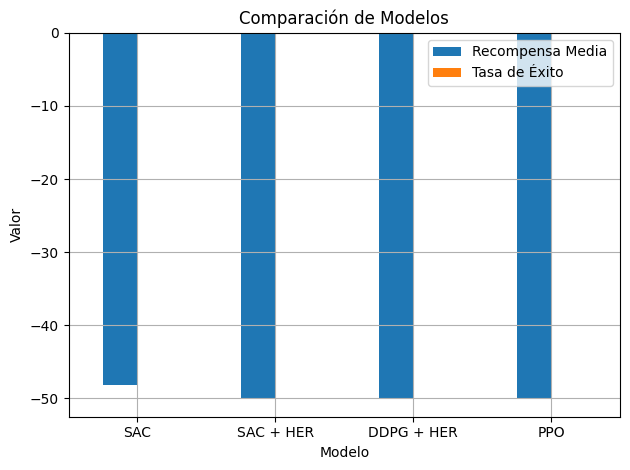

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import SAC, DDPG, PPO

save_dir_sac = "./sac_models/"

# Diccionario con los modelos a comparar
models_info = {
    "SAC": ("./sac_models/sac_final_continuado", SAC),
    "SAC + HER": ("./sac_her_models/sac_her_final_continuado", SAC),
    "DDPG + HER": ("./ddpg_her_models/ddpg_her_final_continuado", DDPG),
    "PPO": ("./fetch_pick_and_place_ppo", PPO),
}

# Evaluación
def evaluate_model(name, path, model_class, episodes=10):
    print(f"Evaluando modelo: {name}")
    test_env = gym.make("FetchPickAndPlace-v4", render_mode=None)
    model = model_class.load(path, env=test_env)

    rewards = []
    success = []

    for _ in range(episodes):
        obs, _ = test_env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = test_env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
        success.append(info.get("is_success", 0.0))

    return {
        "Modelo": name,
        "Recompensa Media": np.mean(rewards),
        "Tasa de Éxito": np.mean(success)
    }

# Evaluar todos los modelos
results = [evaluate_model(name, path, cls) for name, (path, cls) in models_info.items()]
df = pd.DataFrame(results)

# Mostrar tabla de comparación
print("\n[Comparación de rendimiento]")
print(df)

# Visualizar
df.plot(x="Modelo", y=["Recompensa Media", "Tasa de Éxito"], kind="bar", rot=0)
plt.title("Comparación de Modelos")
plt.ylabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()
